# Table of Contents

I. [Exploratory Data Analysis](#i-exploratory-data-analysis)
1. [Data](#1-data)
2. [Understanding The dataset](#2-understanding-the-dataset)
3. [Features](#3-features)

**Questions Shortcut**
1. [How many times the equipment has failed](#33-counting-failures)
2. [Equipment failures by setup configurations (Preset 1 and Preset 2)]()
3. [Equipment failures by their nature/root cause according to parameter readings (temperature, pressure, and others)]()
4. [Create a model (or models) using the technique you think is most appropriate and measure its performance]()
5. [Analyze variable importance]()

# I. Exploratory Data Analysis
After all, we need to understand the context before any machine learning / modeling procedure.

## 0. Enviroment

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from scipy.stats import shapiro, levene, bartlett

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
pd.options.display.max_columns = None

## 1. Data

The dataset contains anonymized time series records of a machine's operation from an FPSO. The recorded variables are as follows:
1.	Cycle: Sequential identifier of measurement cycles.
2.	Preset_1 & Preset_2: Variables that control a specific operating point (OP) of the machine.
3.	Temperature: Temperature recorded in the equipment.
4.	Vibrations (X, Y & Z): Vibrations along the machine's axes.
5.	Frequency: Operating frequency of the machine.
6.	Fail: Variable indicating whether the machine is in a failure state at the given timestamp.

In [3]:
df_oge = pd.read_excel("../data/01_raw/oge_data.xlsx")

## 2. Understanding the dataset
Simple validation of schema, shape and presets.

In [4]:
df_oge = df_oge.sort_values("Cycle")

In [5]:
display(
    df_oge.head(),
    df_oge.shape,
    df_oge.dtypes,
    df_oge.isna().sum()
)

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail
0,1,3,6,44.235186,47.657254,46.441769,64.820327,66.454520,44.483250,False
1,2,2,4,60.807234,63.172076,62.005951,80.714431,81.246405,60.228715,False
2,3,2,1,79.027536,83.032190,82.642110,98.254386,98.785196,80.993479,False
3,4,2,3,79.716242,100.508634,122.362321,121.363429,118.652538,80.315567,False
4,5,2,5,39.989054,51.764833,42.514302,61.037910,50.716469,64.245166,False


(800, 10)

Cycle            int64
Preset_1         int64
Preset_2         int64
Temperature    float64
Pressure       float64
VibrationX     float64
VibrationY     float64
VibrationZ     float64
Frequency      float64
Fail              bool
dtype: object

Cycle          0
Preset_1       0
Preset_2       0
Temperature    0
Pressure       0
VibrationX     0
VibrationY     0
VibrationZ     0
Frequency      0
Fail           0
dtype: int64

In [6]:
# Checking if there's incorrect cycle id
df_id = df_oge[["Cycle"]].reset_index()

df_id["index"] = df_id["index"]+1
df_id["check"] = df_id.eval("index == Cycle")

assert df_id.query("check == False").shape[0] == 0

In [7]:
# number of presets of each type and its use frequency
display(
    df_oge["Preset_1"].value_counts(),
    df_oge["Preset_2"].value_counts(),
)

Preset_1
2    281
1    264
3    255
Name: count, dtype: int64

Preset_2
7    109
6    101
2    101
3    101
5    100
8    100
1     95
4     93
Name: count, dtype: int64

In [8]:
# number of presets combinations and how frequent they are used
df_oge["PresetComb"] = df_oge[["Preset_1", "Preset_2"]].astype(str).agg("".join, axis=1)

df_oge["PresetComb"].value_counts()

PresetComb
13    43
24    40
25    40
38    39
17    38
12    38
26    37
28    37
27    37
16    34
11    34
37    34
22    34
33    32
31    31
34    31
15    31
36    30
21    30
35    29
32    29
23    26
18    24
14    22
Name: count, dtype: int64

==========================================================================================================
- Which variables are manipulated by Preset 1 and 2?
- Preset 2 has more options. Is there a reason for this?
- How each OP (combination of Presets 1 and 2) impact the system (above all, temperature and pressure)?
- Which combination makes the equipment more suspectible to failure?

_Questions discussed further on ([Presets](#32-presets))._

==========================================================================================================

## 3. Features

In [9]:
# Defining features
features = [
    "Temperature",
    "Pressure",
    "VibrationX",
    "VibrationY",
    "VibrationZ",
    "Frequency",
]

### 3.1. Central Tendency

In [10]:
def calculate_measures(
    df: pd.DataFrame,
    features: list,
    measures: list
) -> pd.DataFrame:
    """
    Calculate central tendency `measures` of `features` in a given `dataframe`.
    """

    df_measures = df.agg({feature: measures for feature in features})
    df_measures.loc["range"] = df_measures.loc["max"] - df_measures.loc["min"]

    return df_measures

In [11]:
# some measures of central tendency
measures = ["min", "max", "mean", "median", "std", "skew", "kurtosis"]
df_op_measures = calculate_measures(df_oge[~df_oge["Fail"]], features, measures)
df_fail_measures = calculate_measures(df_oge[df_oge["Fail"]], features, measures)

df_measures = pd.concat(
    [
        df_op_measures.add_suffix("_op"),
        df_fail_measures.add_suffix("_fail")
    ],
    axis=1
)

df_measures.transpose().sort_index()

,min,max,mean,median,std,skew,kurtosis,range
Frequency_fail,48.923777,178.090303,99.812745,99.212676,22.960578,0.432420,1.959404,129.166526
Frequency_op,4.380101,158.811673,65.382995,62.687313,27.943436,0.384159,-0.271089,154.431573
Pressure_fail,50.822002,189.995681,116.422540,110.619156,30.040055,0.519393,-0.150417,139.173679
Pressure_op,3.480279,185.406401,75.632790,71.911241,30.561615,0.524902,0.149601,181.926122
Temperature_fail,48.091962,150.880308,92.469125,90.928964,21.683670,0.186035,0.739854,102.788346
Temperature_op,2.089354,255.607829,67.176884,64.814877,24.824880,1.838670,9.427262,253.518475
VibrationX_fail,20.120467,200.749598,100.167190,98.043755,28.109402,0.672335,2.376813,180.629130
VibrationX_op,3.846343,230.861142,71.494803,66.358594,30.415831,1.303281,3.448406,227.014799
VibrationY_fail,50.481820,193.569947,122.481159,122.115118,30.861777,0.123631,-0.430280,143.088127
VibrationY_op,10.057744,176.197917,68.318455,63.516837,29.010220,0.652150,0.188877,166.140173


==========================================================================================================

Some info that might help analysing the mesures above

**How close to a normal the features distribution are?**

- mean and median are approximately equal
- skewness is close to 0 (symmetric distribution)
- kurtosis is close to 0 (similar flatness to the normal distribution)

**Extra**
- kurtosis > 0 indicates more concetrated distribution
- kurtosis < 0 indicates less concetrated (more dispersed) distribution
- skewness > 0 indicates long tail on the righ side of the distribution
- skewness < 0 indicates long tail on the left side of the distribution

==========================================================================================================

Since validating text values is not ideal, lets take a look on the distributions:

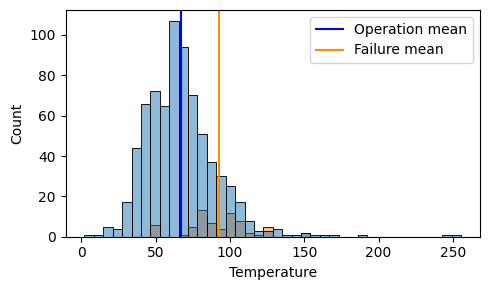

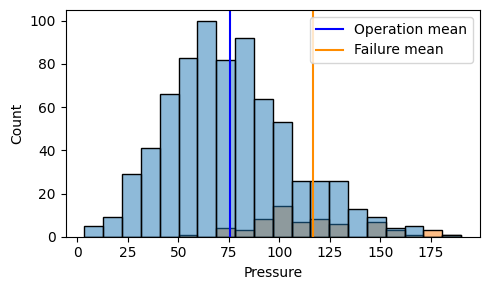

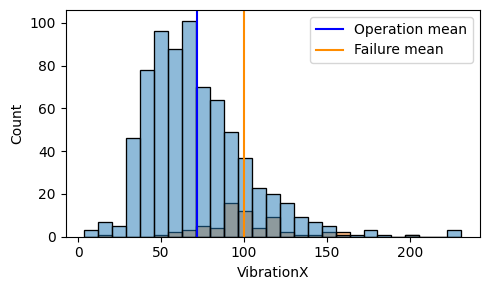

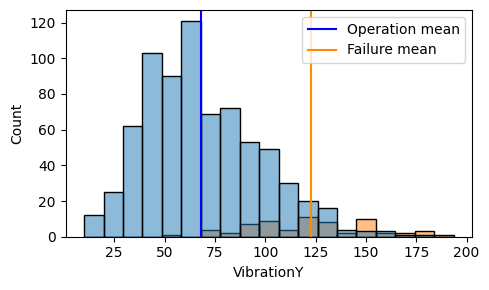

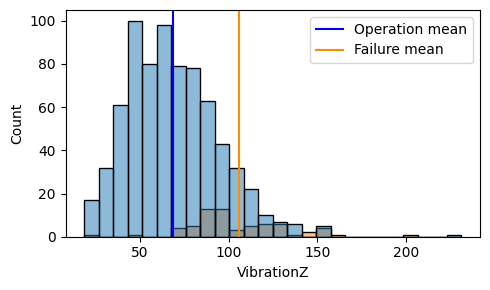

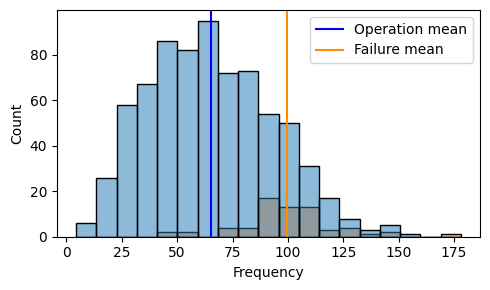

In [12]:
for feature in features:
    mean = df_oge.groupby("Fail")[feature].mean()
    op_mean = mean.loc[False]
    fail_mean = mean.loc[True]

    plt.figure(figsize=(5, 3))
    sns.histplot(
        data=df_oge,
        x=feature,
        hue="Fail",
    )

    plt.axvline(op_mean, color="blue")
    plt.axvline(fail_mean, color="darkorange")

    plt.legend([f"Operation mean", f"Failure mean"])

    plt.tight_layout()
    plt.show()

==========================================================================================================
- At first sight `Temperature`, `Pressure` and `Frequency` distributions seem normal;
- All `Vibration` variables seems to have positive skewness;
- Since modeling failures is the objective, normal distributions can help us with more basic methods such as MAD (Median Absolute Deviation) to set a baseline model;
- That said, the values when normal and failure conditions tend to overlap, giving more complexity to the problem.

==========================================================================================================

Lets check if those distributions are normal using the Shapiro-Wilk test

_H0 = data was drawn from a normal distribution_

In [13]:
shapiro_results = {feature: shapiro(df_oge[feature]) for feature in features}

df_shapiro_results = pd.DataFrame(shapiro_results, index=["statistic", "pvalue"])
df_shapiro_results

,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency
statistic,9.178667e-01,9.801918e-01,9.388416e-01,9.607614e-01,9.622515e-01,9.855061e-01
pvalue,2.016952e-20,6.077752e-09,1.295789e-17,8.234553e-14,1.672456e-13,4.088370e-07


Since all p-values are way below 0.05, the null hypothesis is reject. In other words, none of the distributions are normal.

_This information will be useful ahead._

### 3.2. Variable changes over time

In [14]:
def plot_time_series(
    df_oge: pd.DataFrame,
    features: list,
    xlabel: str = "Cycle",
    fast_moving_mean: bool = True,
    slow_moving_mean: bool = True,
    hide_raw_data: bool = False,
    show_failure_points: bool = False,
    figsize: tuple = (15, 5),
) -> None:
    """
    Generate time series chart with failures identified for each feature in `features` list.

    Args
    ---
    df_oge (pd.DataFrame):
        Dataframe containing time series records of a machine's operation (`Cycle column required`).
    features (list):
        Variables to analyse over time.
    fast_moving_mean (bool):
        Plot moving avarege of the `feature` using a small range of time (3 Cycles/measurements).
    slow_moving_mean (bool):
        Plot moving avarege of the `feature` using a large range of time (or Cycles/measurements).
    hide_raw_data (bool):
        Hide raw measurements from chart to avoid noises.
    """

    x = df_oge[xlabel]
    for feature in features:
        legend = []
        plt.figure(figsize=figsize)
    
        if not hide_raw_data:
            op_series = np.where(df_oge["Fail"], np.nan, df_oge[feature])
            plt.plot(x, op_series, color='b', linewidth=1)

            legend.append(feature)

        if fast_moving_mean:
            fmm = df_oge[feature].rolling(3, min_periods=2).mean()
            plt.plot(x, fmm, color="navy", alpha=.5)
    
            legend.append("Fast Moving Mean")
    
        if slow_moving_mean:
            smm = df_oge[feature].rolling(12, min_periods=2).mean()
            plt.plot(x, smm, color="black", alpha=.8)

            legend.append("Slow Moving Mean")

        if show_failure_points:
            failure_points = df_oge[df_oge["FailStart"]]["Cycle"]
            ymin = df_oge[feature].min()
            ymax = df_oge[feature].max()
            plt.vlines(failure_points, ymin, ymax, color="darkred", linestyle="--")

            legend.append("Failure Point")

        fail_series = np.where(df_oge["Fail"], df_oge[feature], np.nan)
        fail_mean = fail_series[~np.isnan(fail_series)].mean()

        plt.plot(x, fail_series, color='r', linewidth=1, marker="o", markersize=3)
        plt.axhline(fail_mean, color="red", linestyle="--")

        legend += [f"Failure {feature}", f"Avarage failure {feature}"]
        plt.xlabel("Cycle")
        plt.legend(legend, loc="upper left")
        plt.title(f"{feature} over time")
        plt.show()

    return None

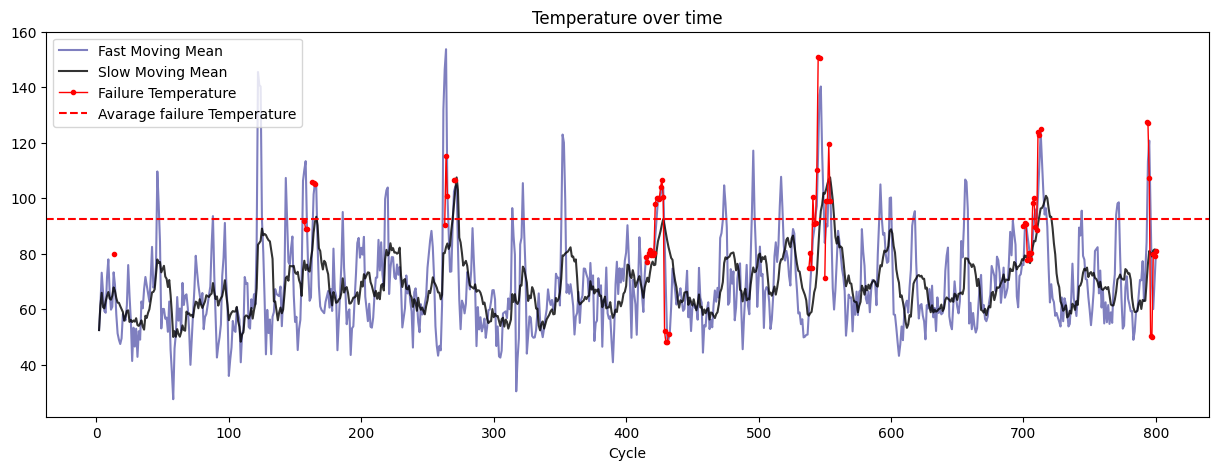

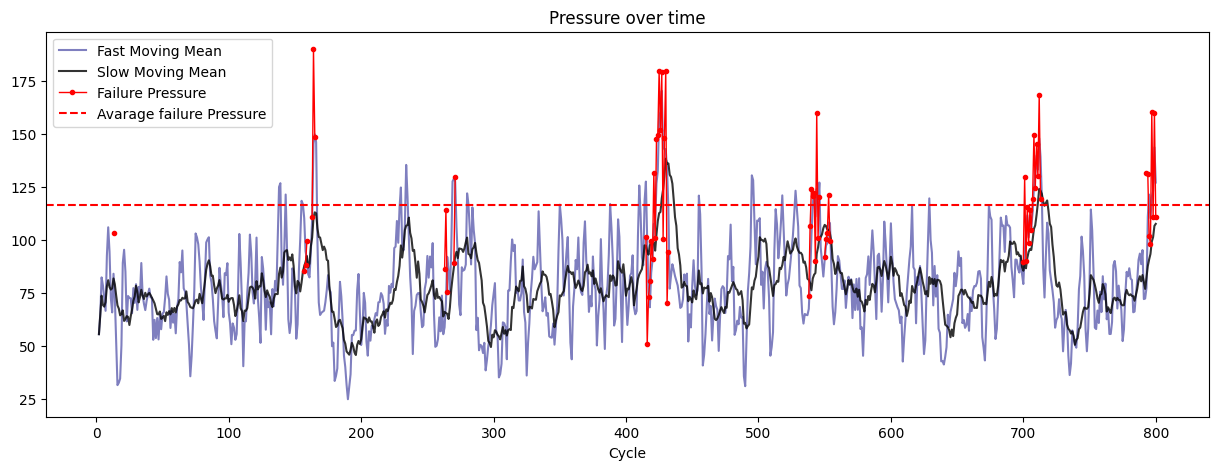

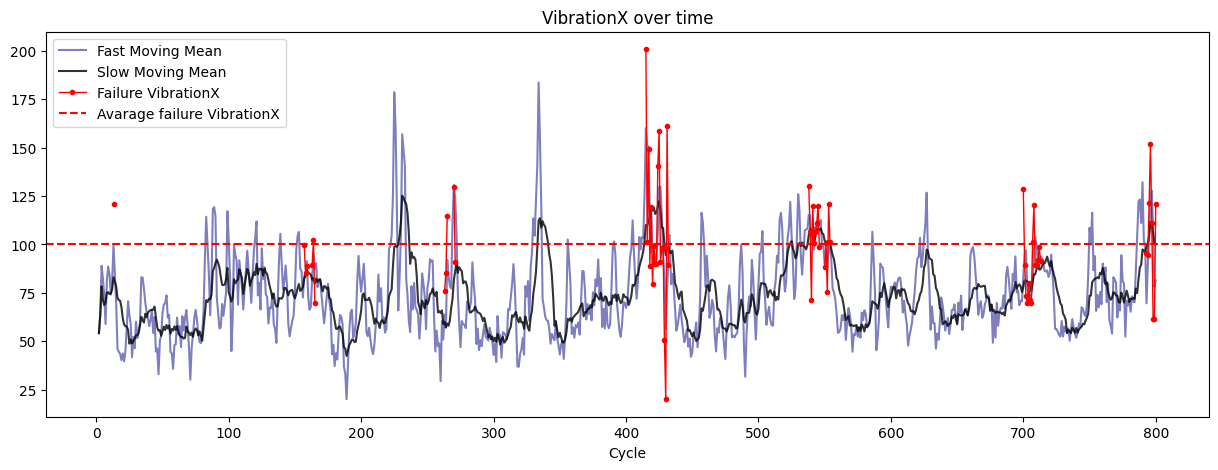

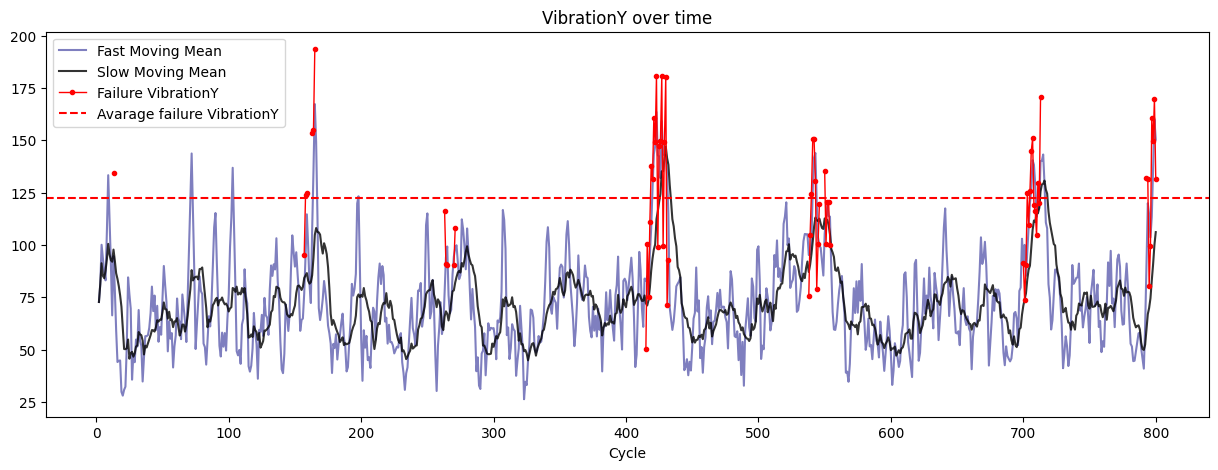

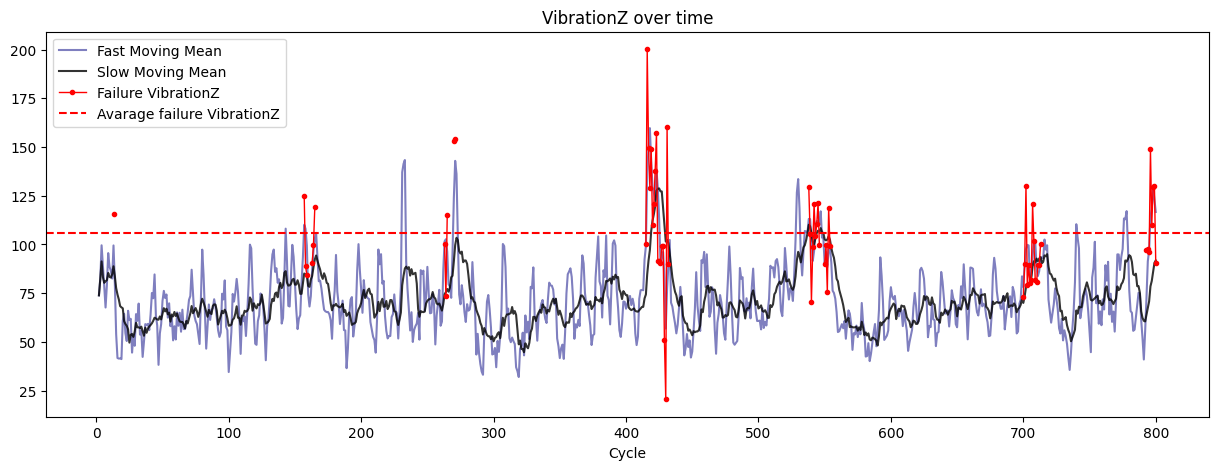

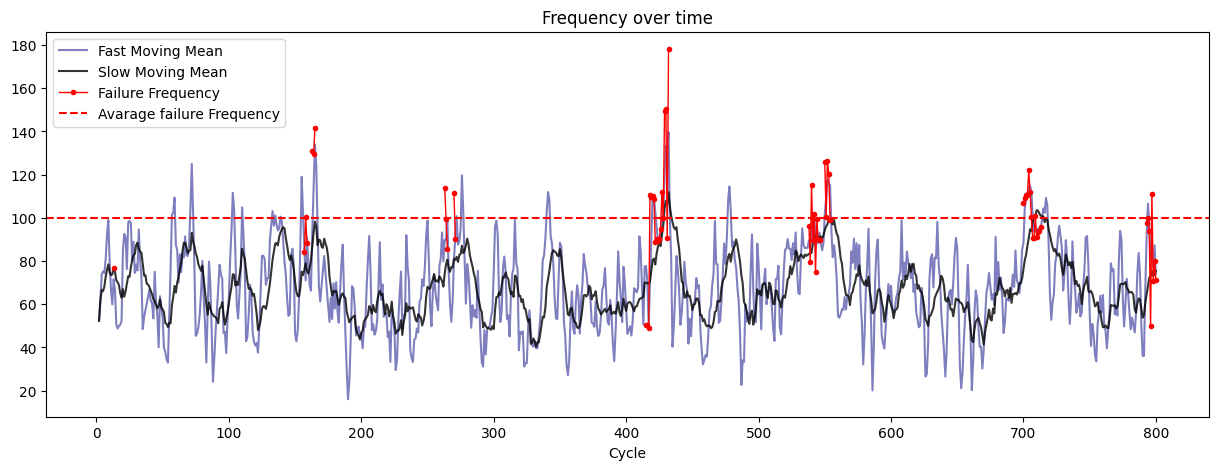

In [15]:
plot_time_series(df_oge, features, hide_raw_data=True)

==========================================================================================================

- Most of the failures seems to occur mainly when `Pressure` goes over an certain value (~120), increasing the `Vibration` on Y and Z directions;
- Feailures are unlikely to occur with negative deviations, probabily because the system/sensor is set to recognize high signals as real problems;
- There is no direct pattern that indicates how Temperature changes on failures scenarios (some high peaks seem to be normal);

==========================================================================================================

### 3.3. Counting failures
Generally failures are not a single point on a time series, but a range. With that in mind, we can calculate how many times the equipment has failed.

In [16]:
# Each time that the equipment has faild is marked as a FailStart
# If the equipment persists on filure state, this shouldn't count as a new failure.
df_oge["FailInt"] = df_oge["Fail"].astype(int)
df_oge["FailStart"] = (df_oge["Fail"]) & (df_oge["FailInt"].shift(1).fillna(0) == 0)

df_oge["FailEnd"] = (df_oge["FailInt"] == 1) & (df_oge["FailInt"].shift(-1) == 0)
df_oge["FailMiddle"] = df_oge["Fail"] & ~df_oge["FailStart"] & ~df_oge["FailEnd"]

In [17]:
failures = df_oge["FailStart"].sum()
print(f"The equipment has failed {failures} times")

The equipment has failed 10 times


Let's check those points using the `plot_time_series` funcion.

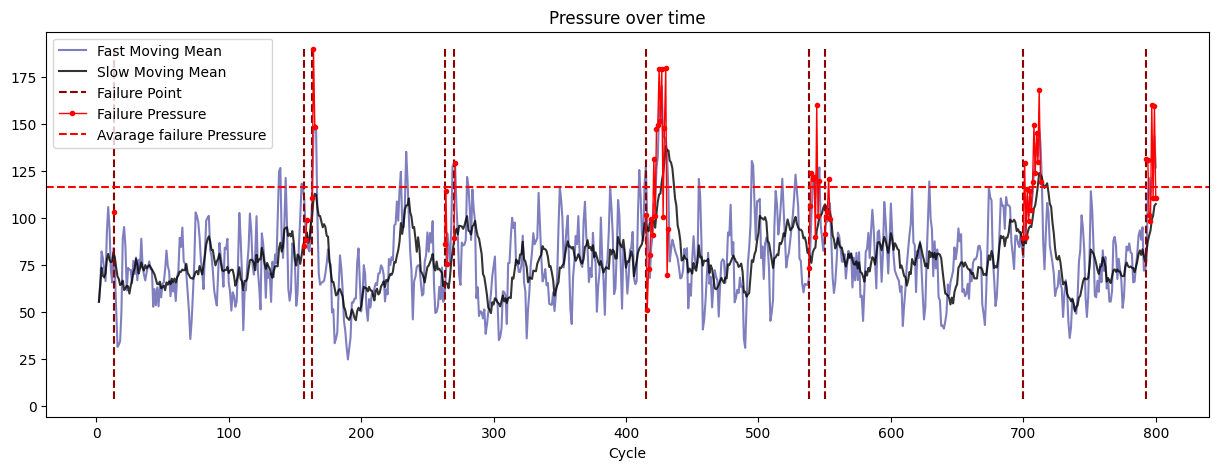

In [18]:
plot_time_series(df_oge, ["Pressure"], hide_raw_data=True, show_failure_points=True)

==========================================================================================================

- Note that some of the failure points (dark red lines) are close to each other, raising suspicion of them being part of the same event.
- The first failure case could be a signal error/misreading, since it doesn't represent a time range.
- However, since we don't have measurements timestamps, this cannot be confirmed.

==========================================================================================================

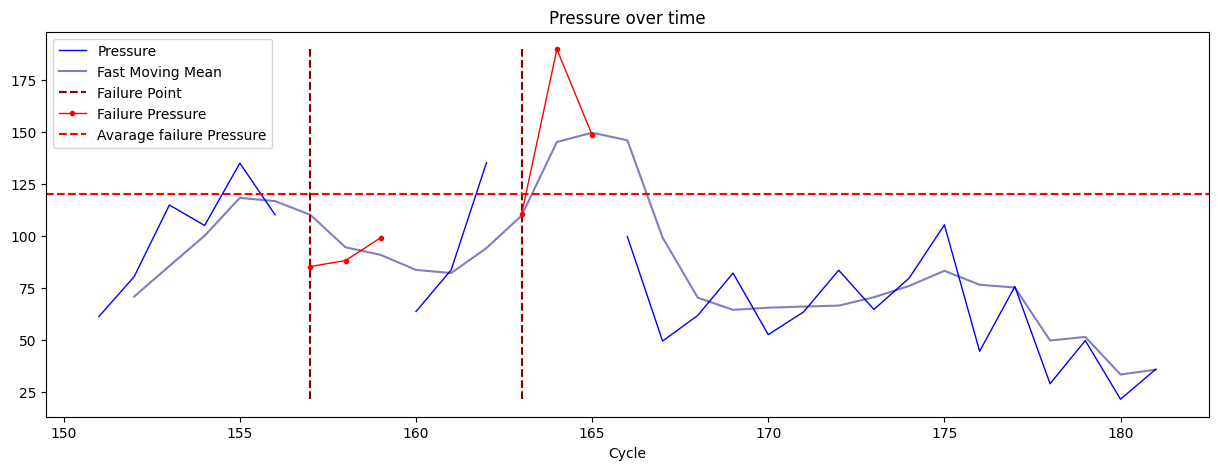

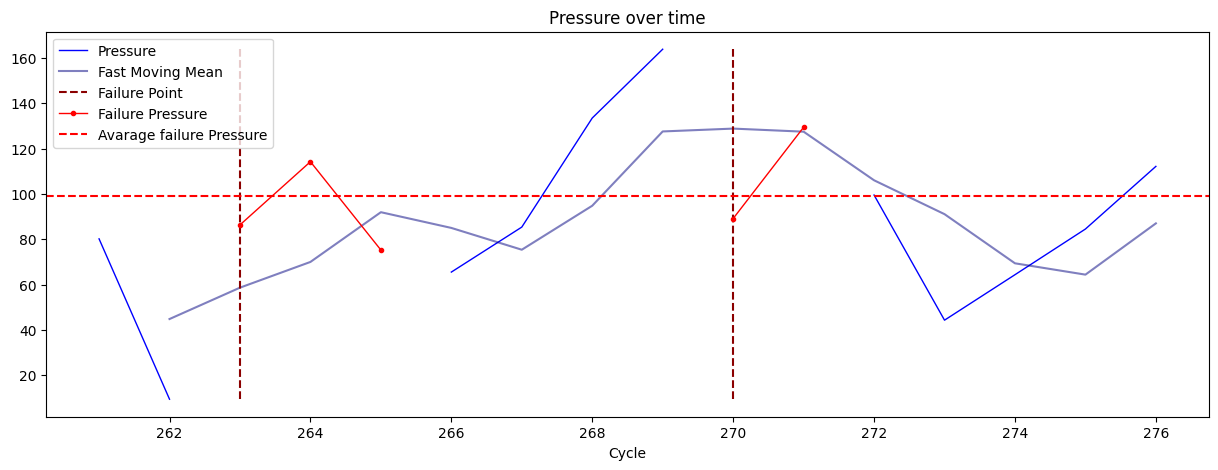

In [19]:
# visualizing close failure points
plot_time_series(
    df_oge.loc[150:180],
    ["Pressure"],
    hide_raw_data=False,
    slow_moving_mean=False,
    show_failure_points=True
)

plot_time_series(
    df_oge.loc[260:275],
    ["Pressure"],
    hide_raw_data=False,
    slow_moving_mean=False,
    show_failure_points=True
)


==========================================================================================================

- Considering all measurements and failure states as corret, the **equipment has failed 10 times**;
- Considering the comments above, it's possible to say that the **equipment has failed 6 times**. 

==========================================================================================================

### 3.4. Interaction Analysis
Feature Relationships and Dependencies

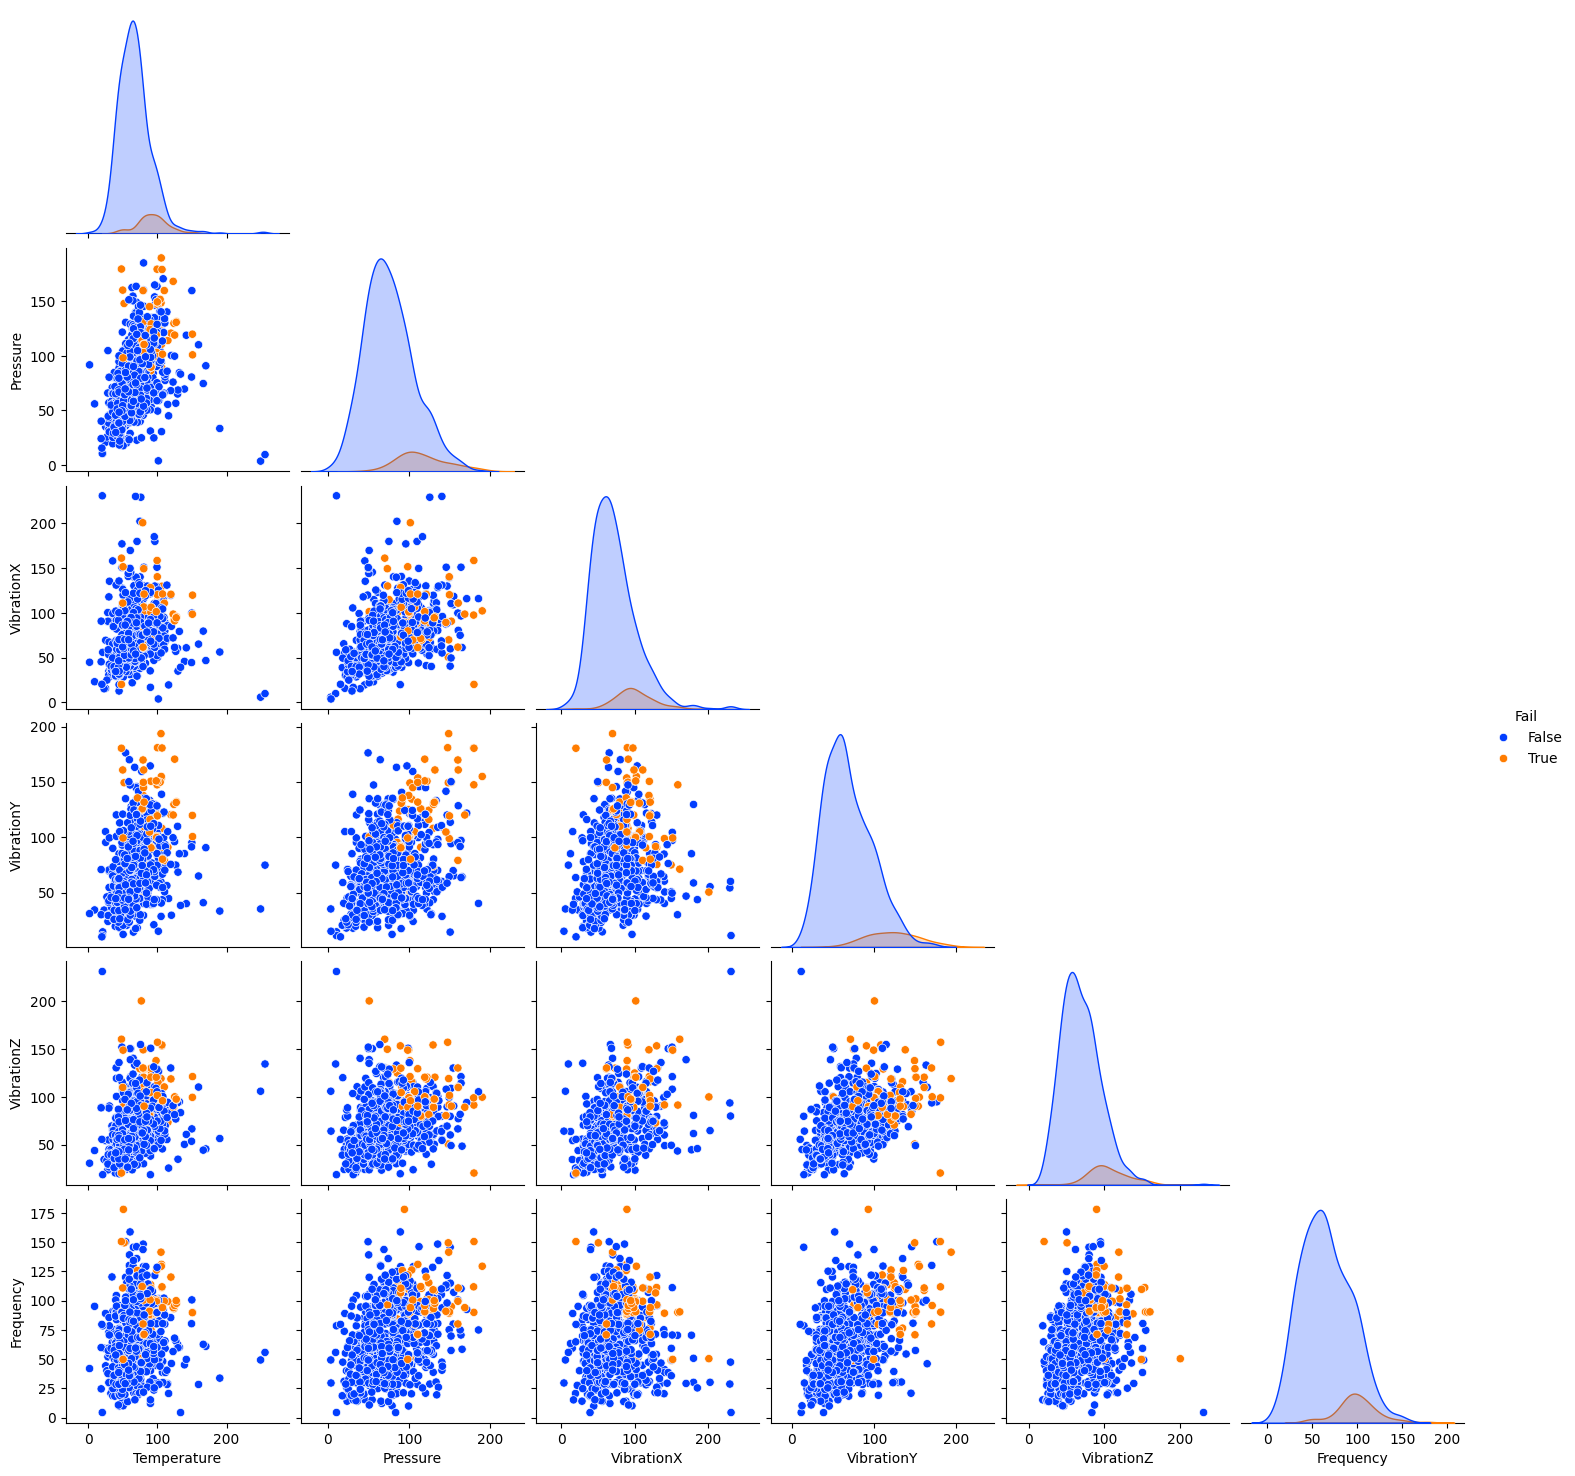

In [20]:
sns.pairplot(
    df_oge[features + ["Fail"]],
    hue="Fail",
    corner=True,
    palette="bright",
);

In [21]:
def plot_heatmap(df_oge, features) -> None:
    """
    Plot correlation and covariation heatmaps.
    """
    fig, ax = plt.subplots(nrows=1, ncols=2)

    fig.set_figwidth(15)
    fig.set_figheight(5)

    sns.heatmap(
        df_oge[features].corr(),
        annot=True,
        cmap="rocket_r",
        linewidths=.5,
        ax=ax[0]
    )

    sns.heatmap(
        df_oge[features].cov().astype(int),
        annot=True,
        cmap="rocket_r",
        linewidths=.5,
        ax=ax[1]
    )

    ax[0].set_title("Correlation Matrix")
    ax[1].set_title("Covariance Matrix")
    plt.show()

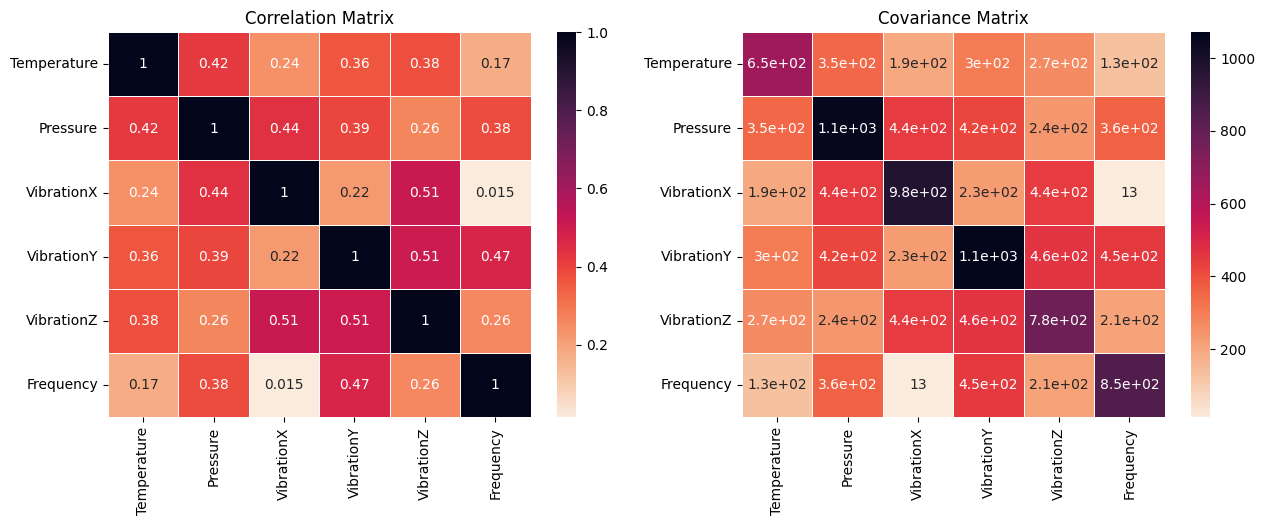

In [22]:
plot_heatmap(df_oge, features)

==========================================================================================================

- Covariance helps us understand how strongly two variables vary togheter. However, this method can be influenced by variance order of magnetude, tha's why we need correlation to perform a better analysis; 

- Based on the plots above, we can see that:
    1. `Pressure` and `VibrationY` fluctuate the most
    2. `Pressure` is a key varible (as commented on [Variable Changes Over Time](#32-variable-changes-over-time)), with strong covariations with almost every other feature and moderate correlation with `Temperature`, `VibrationX` and `VibrationY`;
    3. As expected, `Vibrations` have moderate or strong relationship, which indicates a good set of variables to perform a dimensionality reduction.
    4. Since we have `Frequency` data we're probabily working with a rotary machine (eg. Centrifugal Pump/Compressor, weak vibration dominance in axial direction) and this variable could be included on the dimensionality reduction.

==========================================================================================================

### 3.5. Dimensionality Reduction
Performing Dimensionality Reduction using PCA

#### 3.5.1. First Approach
Using `VibrationX`, `VibrationY`, `VibrationZ` and `Frequency` to perform PCA.

In [23]:
def perform_pca(
    df: pd.DataFrame,
    pca_features: list,
    n_components: int,
    output_name: str="Vibration",
) -> tuple:
    """"""
    std_scaler = StandardScaler()

    pca = PCA(n_components=n_components)
    std_features = [f"std_{c}" for c in pca_features]

    # Performing PCA
    df[std_features] = std_scaler.fit_transform(df[pca_features])

    components_cols = [f"{output_name}PC{i}" for i in range(n_components)]
    pca_results = pca.fit_transform(df[pca_features])

    return components_cols, pca_results, pca

To check if the PCA is feasible, lets perform a Levene test for equal veriances (if the distributions were normal, the Bartlett test would be an option)

_H0: Input samples are from populations with equal variances_

In [24]:
samples = df_oge["VibrationX"], df_oge["VibrationY"], df_oge["VibrationZ"], df_oge["Frequency"]

levene_stat, levene_p = levene(*samples)
bartlett_stat, bartlett_p = bartlett(*samples)

print(levene_stat, levene_p)
print(bartlett_stat, bartlett_p)

5.940257477056524 0.0004896549768668475
24.74825756885452 1.742959153032024e-05


Both tests suggests that the populations do not have equal variances (very small p-value)

In [25]:
pca_features = ['VibrationX', 'VibrationY', 'VibrationZ', 'Frequency']
components = len(pca_features)
# Using maximum value of components to perform analysis

components_cols, pca_results, pca1 = perform_pca(df_oge, pca_features, components)
df_oge[components_cols] = pca_results

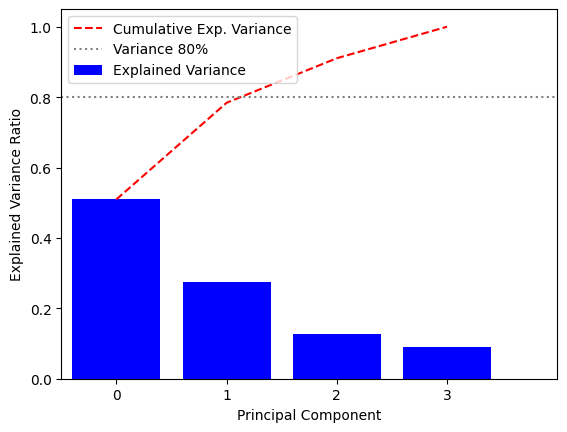

[0.50956963 0.27439538 0.12651778 0.08951721]
[0.50956963 0.783965   0.91048279 1.        ]


In [26]:
# Understanding results
components = len(pca_features)
explained_var = pca1.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

plt.bar(range(components), explained_var, color="b")
plt.plot(range(components), cumulative_var, linestyle='--' , color='r')
plt.axhline(0.8, linestyle='dotted', color='gray')

plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.legend(['Cumulative Exp. Variance', 'Variance 80%', 'Explained Variance'], loc="upper left")

plt.xticks(range(components))
plt.xlim(-0.5, components)
plt.show()

print(explained_var)
print(cumulative_var)

==========================================================================================================

- Half of the variance can be explained with only 1 component (redundancy across `Vibration Y`, `Vibration Z` with `Frequency`) and ~80% can be explained with 2 of them;
- Using only PC0 can be reasonable if our goal is a simple measure of overall vibration/frequency intensity, but this can lead to some interpretability loss because 27% of variance carried by PC1.

==========================================================================================================

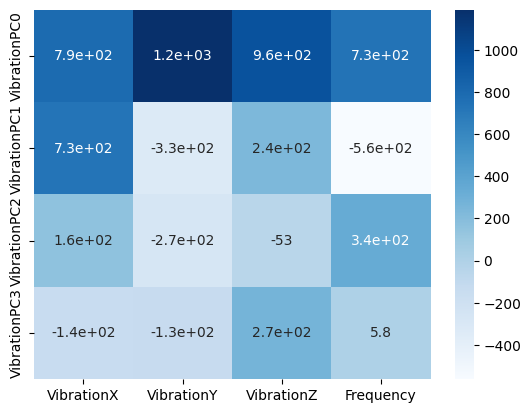

In [27]:
# How PCA components relate back to the original features
cov_matrix = df_oge[pca_features + components_cols].cov()
cov_matrix = cov_matrix.drop(components_cols, axis=1)
cov_matrix = cov_matrix.loc[components_cols]

sns.matrix.heatmap(cov_matrix, annot=True, cmap="Blues")

plt.show()

==========================================================================================================

- As expected, all covariance values with PC0 are large and positive, capturing the overall vibration magnitude;
- PC1 shows different directions depending on the feature, possibly capturing imbalance along axes

==========================================================================================================

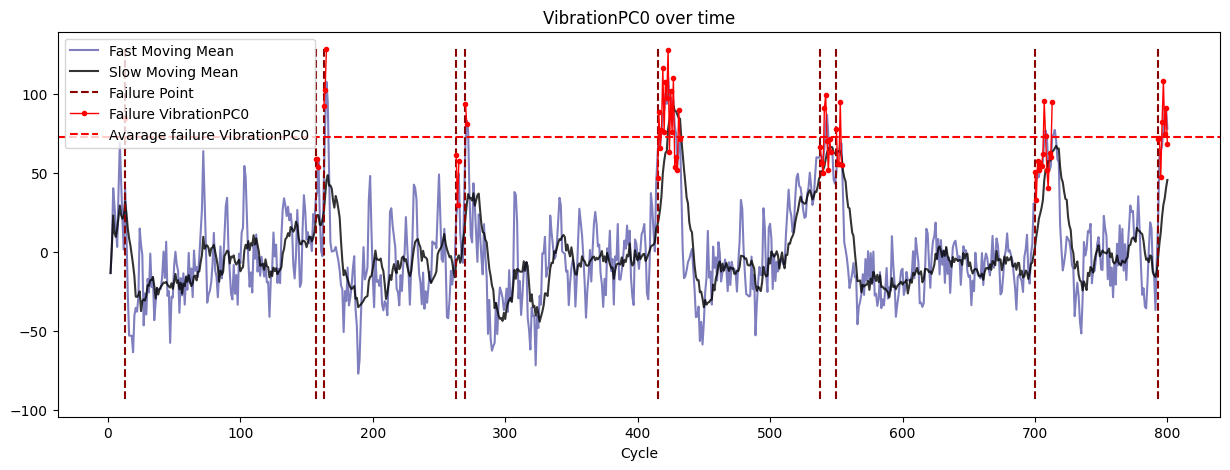

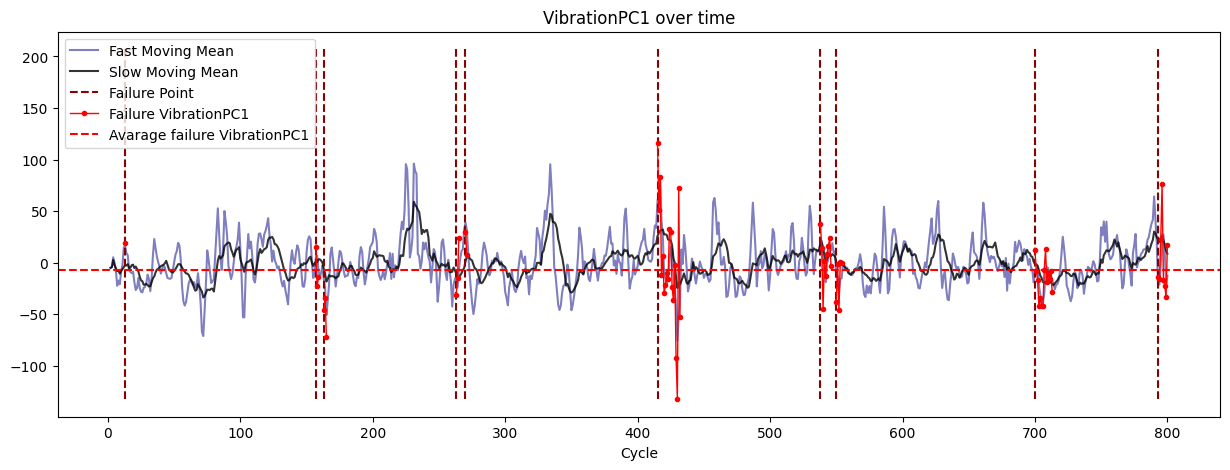

In [28]:
plot_time_series(df_oge, ["VibrationPC0", "VibrationPC1"], hide_raw_data=True, show_failure_points=True)

==========================================================================================================

- Looking back at the time series, the difference in failure scenarius is visible. While PC0 values are high and easier to distinguish, PC1 is close to the center (~0)

==========================================================================================================

#### 3.5.2. Second Approach
Let's calculate Vibration RMS (Root Mean Square) with `VibrationX`, `VibrationY`, `VibrationZ` and utilize this new feature to eprform a PCA with `Frequency`.

RSM vibration is a widely used metric to express a vibration level.

_ref.: [The Peak, Peak to Peak and RMS values in vibration analysis](https://dynamox.net/en/blog/the-peak-peak-to-peak-and-rms-values-in-vibration-analysis)_

In [29]:
df_oge["VRMS"] = np.sqrt((df_oge[["VibrationX", "VibrationY", "VibrationZ"]]**2).sum(axis=1)/3)

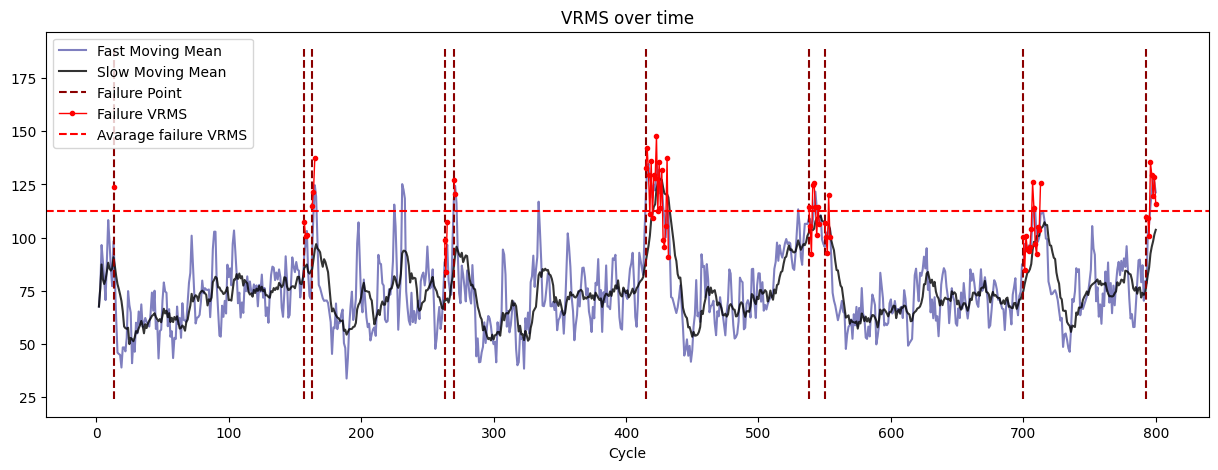

In [30]:
plot_time_series(df_oge, ["VRMS"], hide_raw_data=True, show_failure_points=True)

==========================================================================================================

- With this new metric, theres no "vibration points" on negative peaks like observed before on [3.2](#32-variable-changes-over-time)

==========================================================================================================

_Modeling task: Test which feature best perform on the final model (VibrationPC0 or VRMS). With the same origin, they shouldn't be used together._

In [31]:
# Since Vibrations were used to perform PCA, they'll not be used further on
features = ['Temperature', 'Pressure', 'VibrationPC0', 'VRMS', 'Frequency']

In [32]:
df_oge[["VRMS", "VibrationPC0"]].corr()
# as expected, correlation between RMS and PCA methods outputs are strong

,VRMS,VibrationPC0
VRMS,1.000000,0.937852
VibrationPC0,0.937852,1.000000


## 4. Presets

### 4.1. Preset Combinations
How preset combinations changes the equipment conditions?

_Hypothesis: Preset combinations have well defined ranges of Temperature and Pressure_

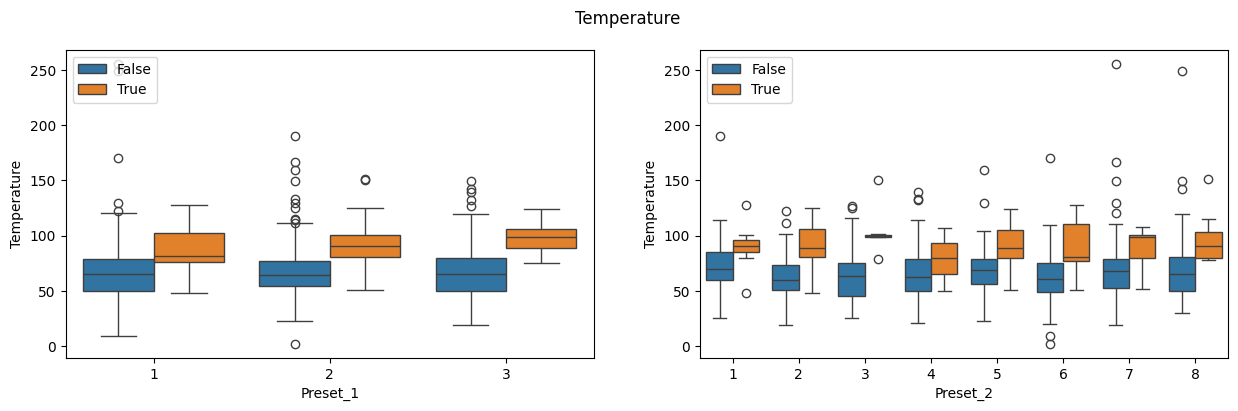

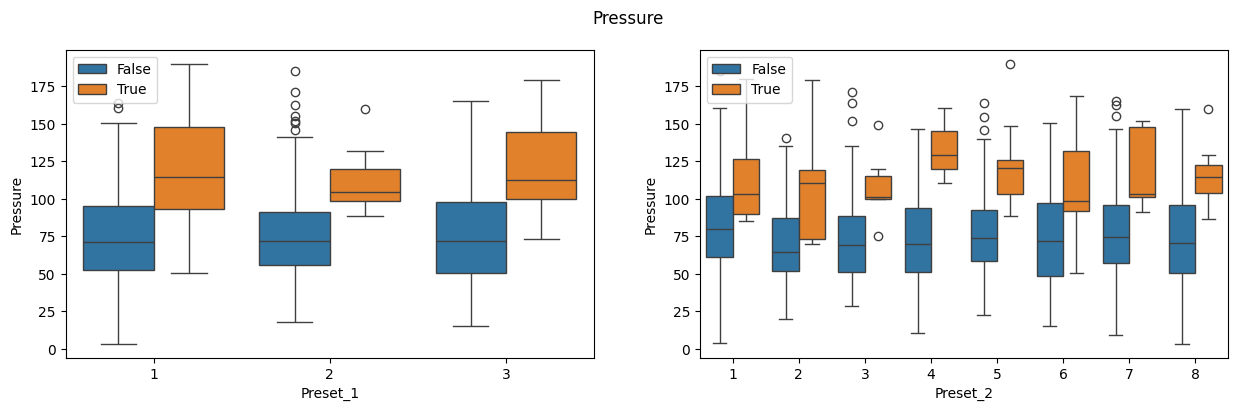

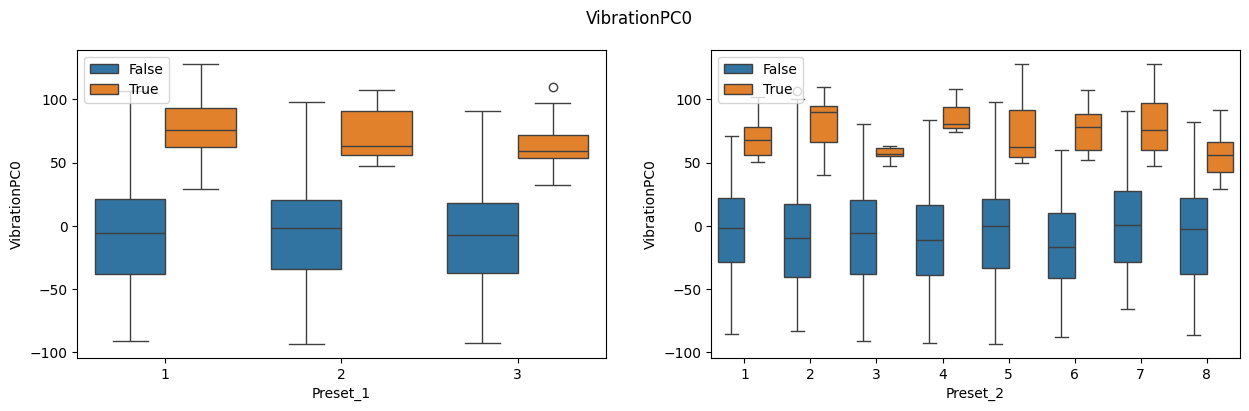

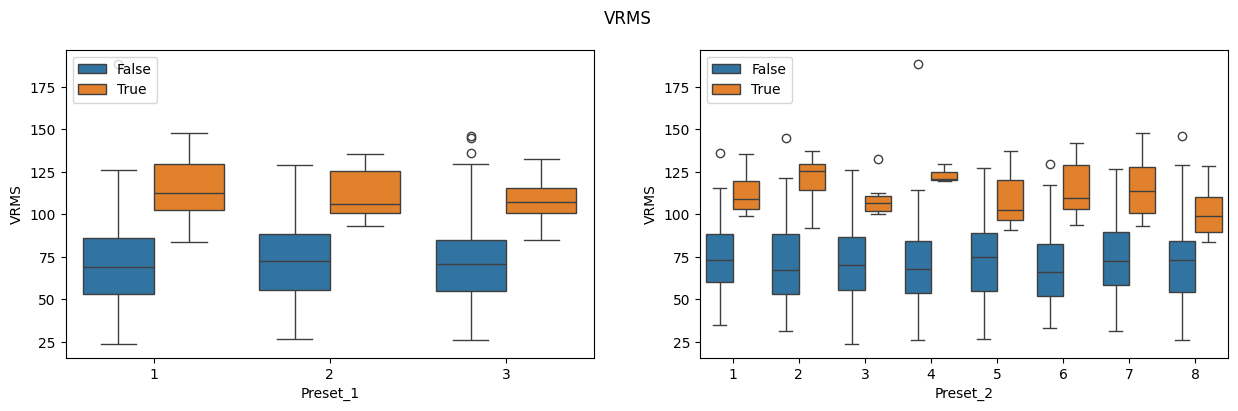

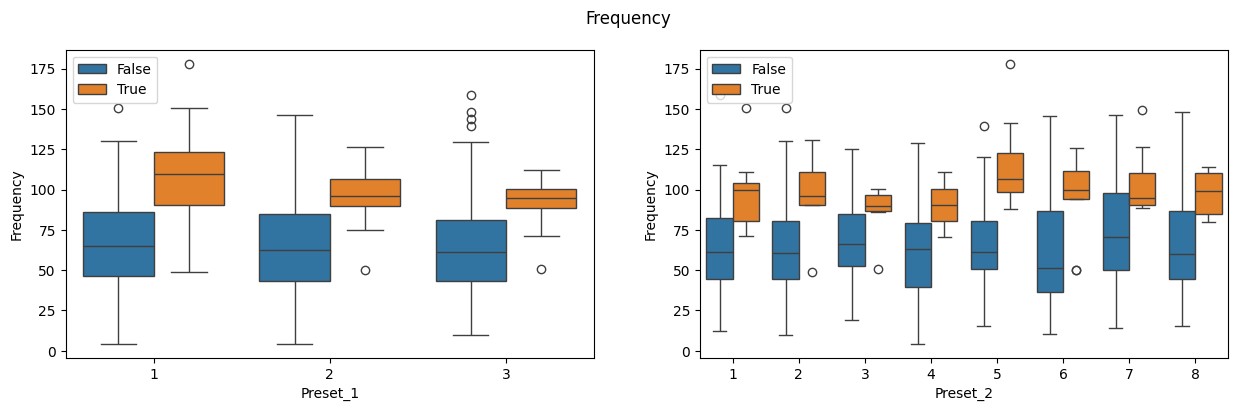

In [33]:
# Isolated presets
# Since the preset 1 and 2 are combined to create an Operational Point, we must'n expect much from the isolated analysis.
for variable in features:
    fig, ax = plt.subplots(nrows=1, ncols=2)

    fig.set_figwidth(15)
    fig.set_figheight(4)

    sns.boxplot(
        data=df_oge,
        x="Preset_1",
        y=variable,
        hue="Fail",
        ax=ax[0],
    )

    sns.boxplot(
        data=df_oge,
        x="Preset_2",
        y=variable,
        hue="Fail",
        ax=ax[1],
    )

    ax[0].legend(loc="upper left")
    ax[1].legend(loc="upper left")

    plt.suptitle(variable)
    plt.show()

==========================================================================================================

- There's a clear difference on the signals recieved from failures and normal operation, mainly because these scenarios don't occur at negative peaks (as seen before);
- Can't confirm the variables manipulated or controled by each preset (similar mean and intervals);
- That said, the tails of variables distribution are quite long.

_What if we use metrics like fast/slow moving mean to avoid noise?_

==========================================================================================================

In [34]:
# Moving mean and median
for feature in features:
    df_oge[f"{feature}_fmm"] = df_oge[feature].rolling(3, min_periods=2).mean()
    df_oge[f"{feature}_smm"] = df_oge[feature].rolling(12, min_periods=2).mean()

    df_oge[f"{feature}_fmmd"] = df_oge[feature].rolling(3, min_periods=2).median()
    df_oge[f"{feature}_smmd"] = df_oge[feature].rolling(12, min_periods=2).median()

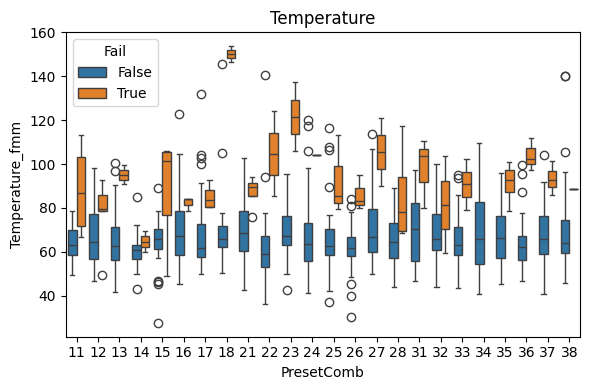

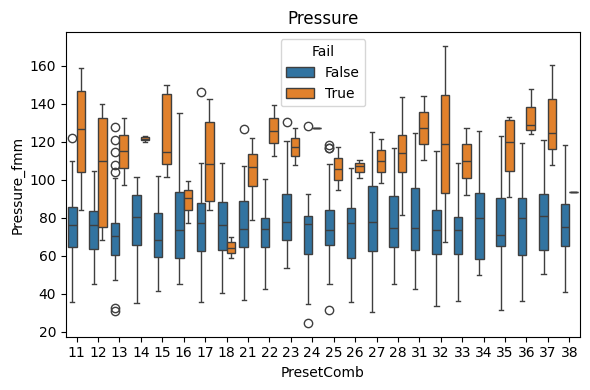

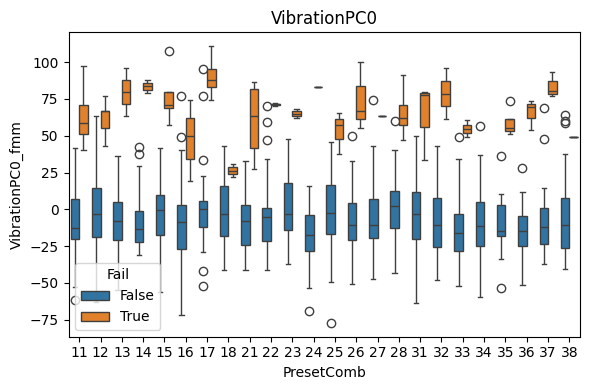

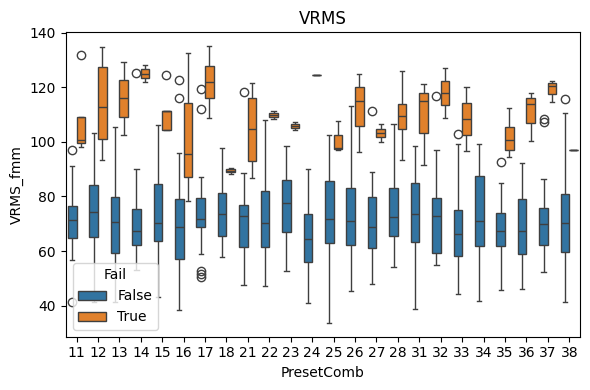

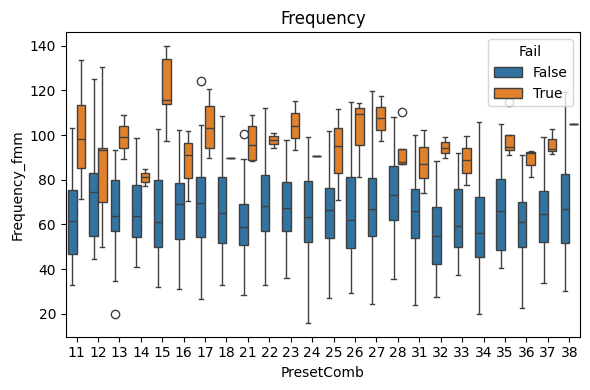

In [35]:
# Combined presets (Isolated doesn't help that much)
for variable in features:
    plt.figure(figsize=(6, 4))

    sns.boxplot(
        data=df_oge.sort_values("PresetComb"),
        x="PresetComb",
        y=f"{variable}_fmm",
        hue="Fail"
    )

    plt.title(variable)
    plt.tight_layout()
    plt.show()

Long tails still a problem, let's remove some outliers

In [36]:
from typing import Union

def remove_outliers_iqr(
    df:pd.DataFrame,
    feature: str,
    group: Union[str, list]=["Fail", "PresetComb"],
) -> pd.DataFrame:
    """
    Remove outliers within each `group` in a given DataFrame `df`.
    """
    q1 = df.groupby(group)[feature].transform(lambda x: x.quantile(0.25))
    q3 = df.groupby(group)[feature].transform(lambda x: x.quantile(0.75))

    distance = 1.5 * (q3 - q1)
    lower_bound, upper_bound = q1 - distance, q3 + distance

    not_outlier = df[feature].between(lower_bound, upper_bound)
    df_woo = df[not_outlier].copy()

    df_wo = df[~not_outlier].copy()
    print(f"{df_wo.shape[0]} {feature} outliers removed")
    # should be a logger specifying the outliers removed within each group

    return df_woo

45 Temperature_fmm outliers removed
42 Temperature_fmmd outliers removed


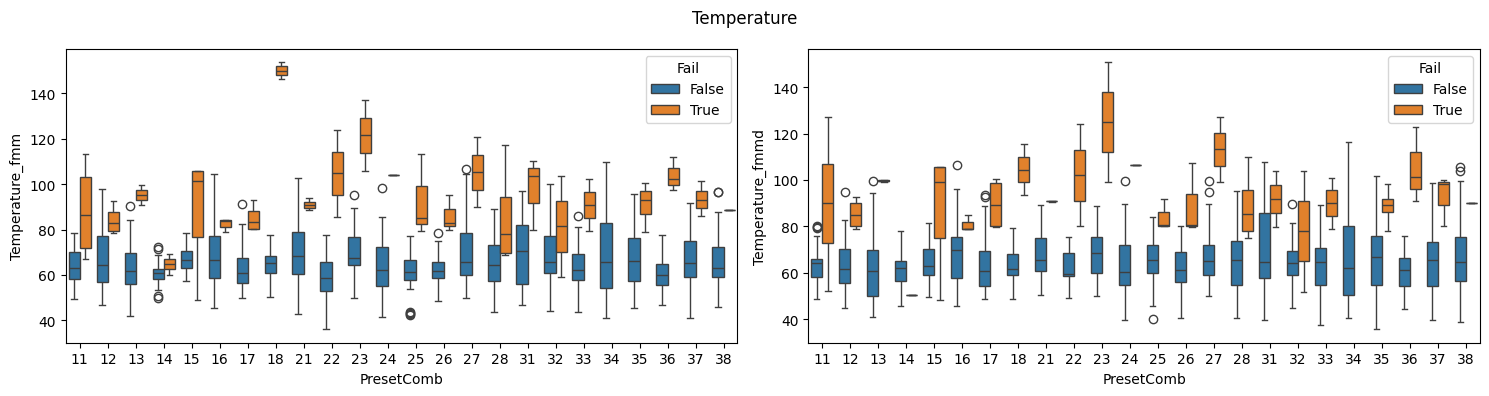

18 Pressure_fmm outliers removed
18 Pressure_fmmd outliers removed


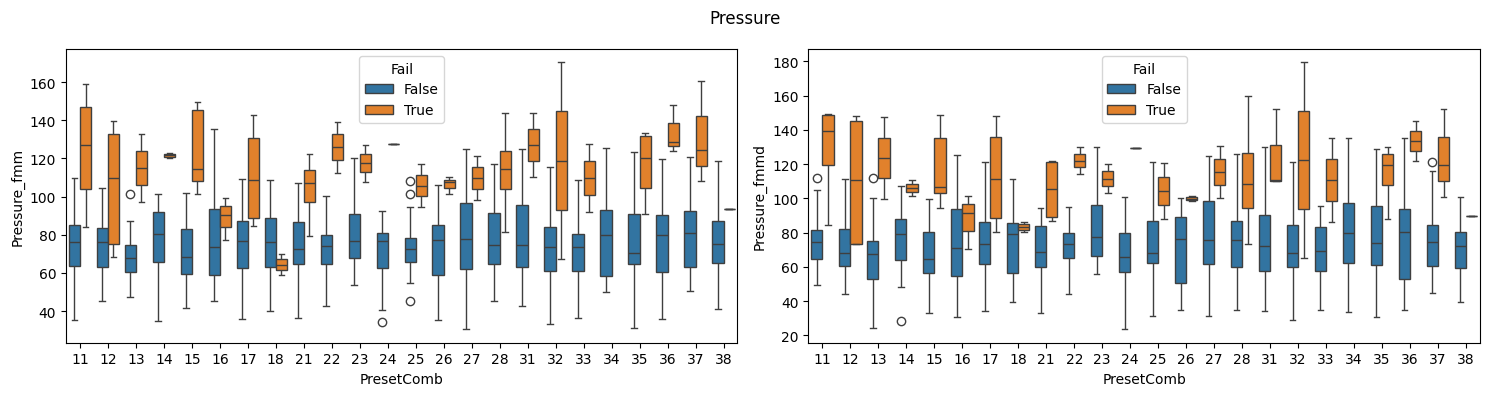

31 VibrationPC0_fmm outliers removed
25 VibrationPC0_fmmd outliers removed


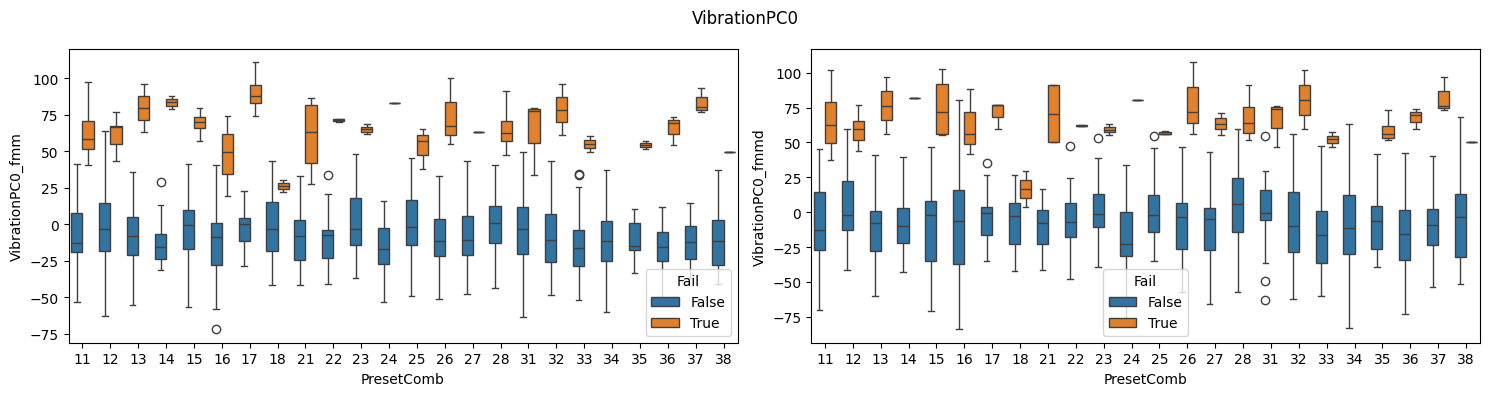

21 VRMS_fmm outliers removed
12 VRMS_fmmd outliers removed


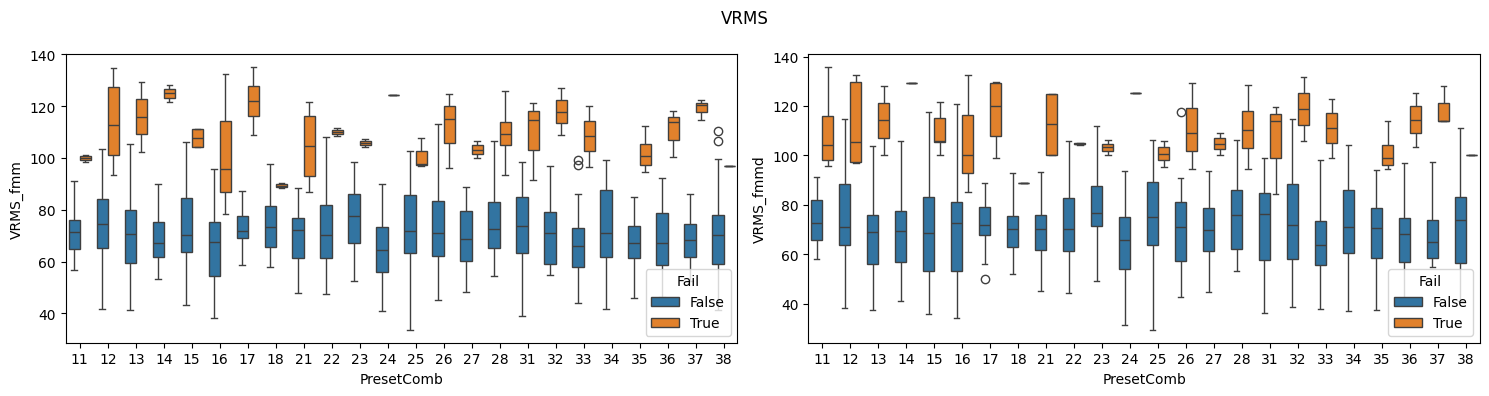

6 Frequency_fmm outliers removed
10 Frequency_fmmd outliers removed


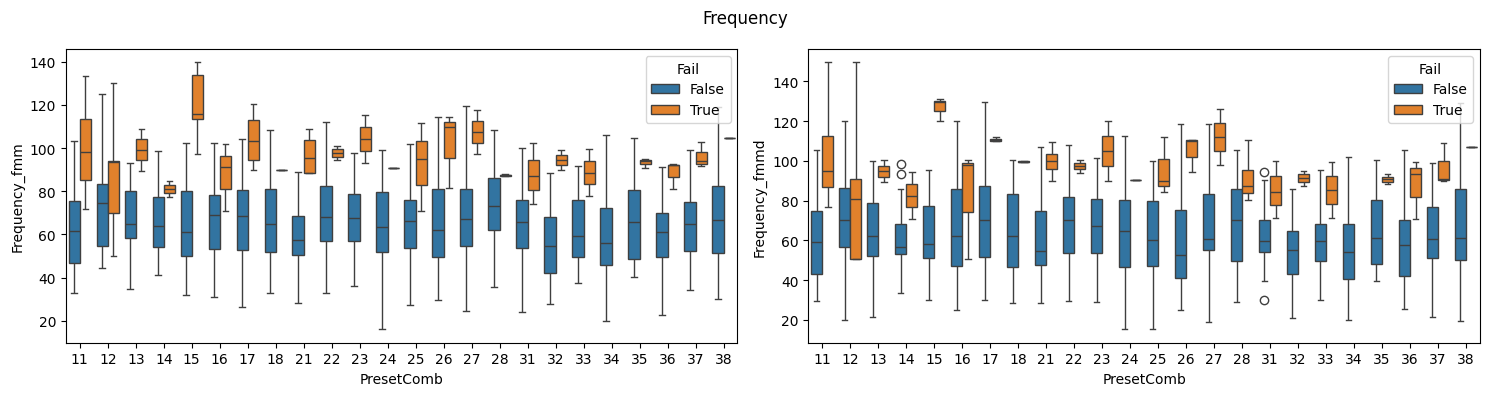

In [37]:
for variable in features:
    fig, ax = plt.subplots(nrows=1, ncols=2)
    fig.set_figwidth(15)
    fig.set_figheight(4)

    # mean
    _var_mean = f"{variable}_fmm"
    _df_mean = remove_outliers_iqr(df_oge, _var_mean)

    # median (less affected by extreme values)
    _var_median = f"{variable}_fmmd"
    _df_median = remove_outliers_iqr(df_oge, _var_median)

    sns.boxplot(
        data=_df_mean.sort_values("PresetComb"),
        x="PresetComb",
        y=_var_mean,
        hue="Fail",
        ax=ax[0],
    )

    sns.boxplot(
        data=_df_median.sort_values("PresetComb"),
        x="PresetComb",
        y=_var_median,
        hue="Fail",
        ax=ax[1],
    )

    plt.suptitle(variable)
    plt.tight_layout()
    plt.show()

==========================================================================================================
- Since seaborn boxplot already identifies outlier by iqr method, we just got rid of most extreme points;
- Utilizing the median helped with the long tail problems in some cases. However, the problem still existis.

==========================================================================================================

In [38]:
# # Isolated presets
# # Since the preset 1 and 2 are combined to create an Operational Point, we must'n expect much from the isolated analysis.
# for variable in features:
#     fig, ax = plt.subplots(nrows=1, ncols=2)

#     fig.set_figwidth(15)
#     fig.set_figheight(4)

#     _var = f"{variable}_fmm"
#     _df = remove_outliers_iqr(df_oge, _var)

#     sns.boxplot(
#         data=_df,
#         x="Preset_1",
#         y=_var,
#         hue="Fail",
#         ax=ax[0],
#     )

#     sns.boxplot(
#         data=_df,
#         x="Preset_2",
#         y=_var,
#         hue="Fail",
#         ax=ax[1],
#     )

#     ax[0].legend(loc="upper left")
#     ax[1].legend(loc="upper left")

#     plt.suptitle(variable)
#     plt.show()

### 4.2. Dealing with failures
How does the system/operator changes the Presets when a fail occurs?

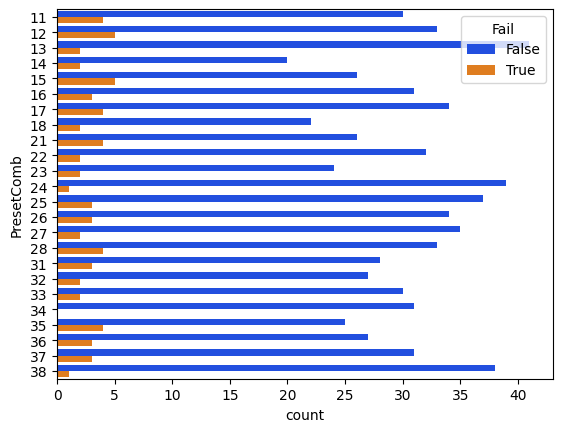

In [39]:
# Failures measurements by presets combinations
df_preset_fail = df_oge.groupby(
    ["PresetComb", "Fail"], as_index=False
).agg(
    count=("Cycle", "count")
)

sns.barplot(
    df_preset_fail,
    x="count",
    y="PresetComb",
    hue="Fail",
    palette="bright"
)

plt.show()

Only combination `34` was not used during a fail scenario.

Let's separate different stages of a failure.

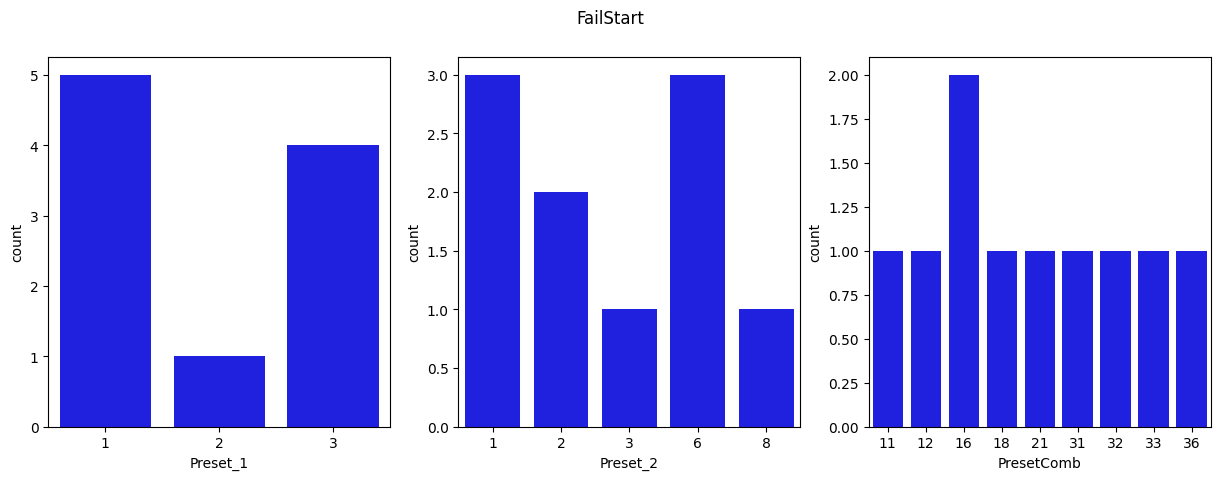

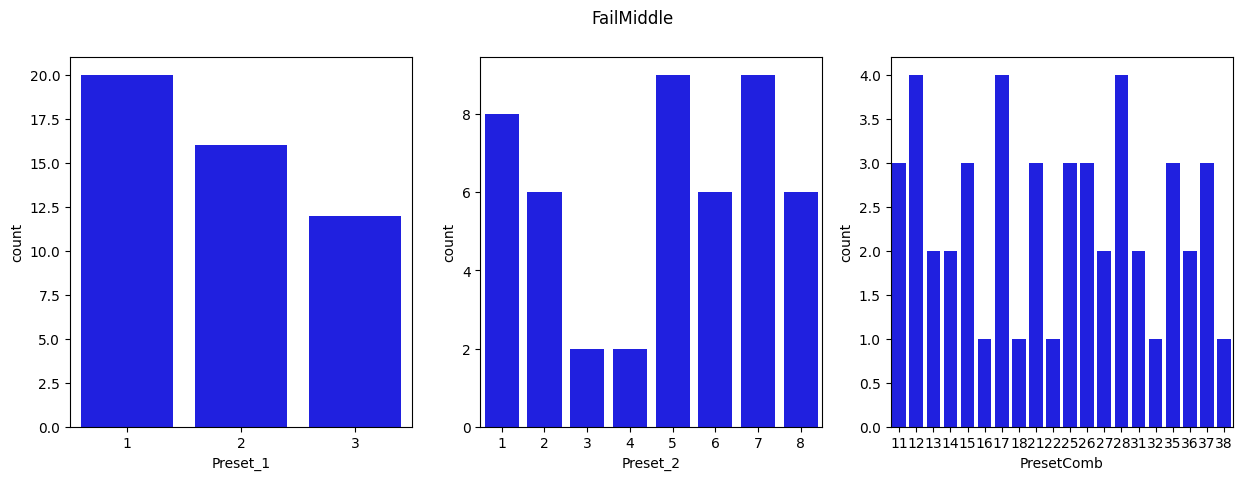

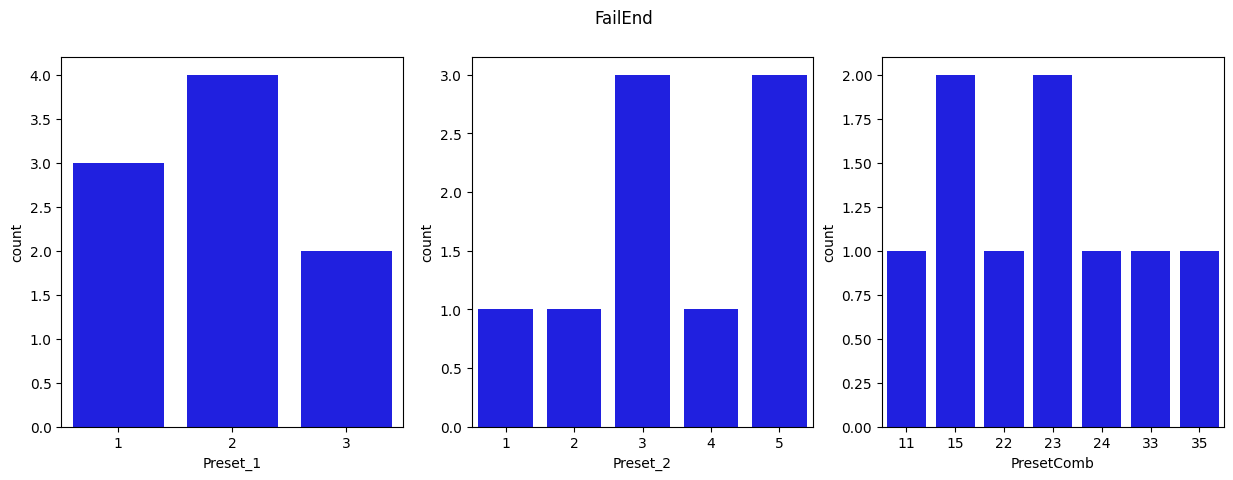

In [40]:
for stage in ["FailStart", "FailMiddle", "FailEnd"]:
    fig, ax = plt.subplots(nrows=1, ncols=3)
    fig.set_figwidth(15)

    sns.barplot(
        df_oge[df_oge[stage]]["Preset_1"].value_counts().sort_index(),
        ax=ax[0],
        color="b",
    )

    sns.barplot(
        df_oge[df_oge[stage]]["Preset_2"].value_counts().sort_index(),
        ax=ax[1],
        color="b",
    )

    sns.barplot(
        df_oge[df_oge[stage]]["PresetComb"].value_counts().sort_index(),
        ax=ax[2],
        color="b",
    )

    plt.suptitle(stage)
    plt.show()

==========================================================================================================
- Most of the failures occurs when `Preset_1` is 1 or 3, and, when `Preset_2` is 1 or 6;
- Theres no failure beginning when `Preset_2` is 4, 5 or 7.
- `Preset_2` 5 and 7 states seems to be used as safety measures, since they're present only during the fail (Note that state 7 doesn't appear after failure end - `FailEnd`)

==========================================================================================================

## 5. Failure root cause
Categorizing root cause of failures.

Since the goal here is acheive a global otimization of root causes along failures, KMeans was choose because its a simple algorithm and easy to explain and calibrate.

In [202]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score

In [203]:
def remove_outliers(
    df:pd.DataFrame,
    feature: str,
) -> pd.DataFrame:
    """
    Remove outliers using iqr method.
    """
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)

    distance = 1.5 * (q3 - q1)
    lower_bound, upper_bound = q1 - distance, q3 + distance

    not_outlier = df[feature].between(lower_bound, upper_bound)
    df_woo = df[not_outlier].copy()
    df_wo = df[~not_outlier].copy()

    print(f"{df_wo.shape[0]} outliers from {feature} removed")
    # should be a logger specifying the outliers removed within each group

    return df_woo

In [204]:
scaler = MinMaxScaler()
rs = 42  # Random State
cluster_features = ['Temperature', 'Pressure', 'VibrationPC0']
suffix = ["smm"]  # ["smm", "smmd"]
cluster_features = [f"{c}_{s}" for c in cluster_features for s in suffix]

# Utilizing the mean stead of the raw variavle can help the model to understend
# what came before certain time series point

==========================================================================================================
First try with 3 features because:
1. It's easier to visualize in a 3d space
2. 4 variables (Vibrations and Frequency) are explained by one Principal Component

==========================================================================================================

In [205]:
# Creating ID for each failure
df_oge["StateID"] = (df_oge["Fail"] != df_oge["Fail"].shift(1)).cumsum()
df_failure = df_oge[df_oge["Fail"]].copy()

In [206]:
df_woo = df_failure.copy()
for feature in cluster_features:
    df_woo = remove_outliers(df_woo, feature)

5 outliers from Temperature_smm removed
3 outliers from Pressure_smm removed
0 outliers from VibrationPC0_smm removed


### 5.1. First Approach
Every measure can be clustered as a single event

In [207]:
# KMeans is highly influenced by the features magnetude, thats why a scaler is needed.
df_features = df_woo[cluster_features].copy()
df_features[cluster_features] = scaler.fit_transform(df_features)

In [208]:
print(df_features.shape)

(58, 3)


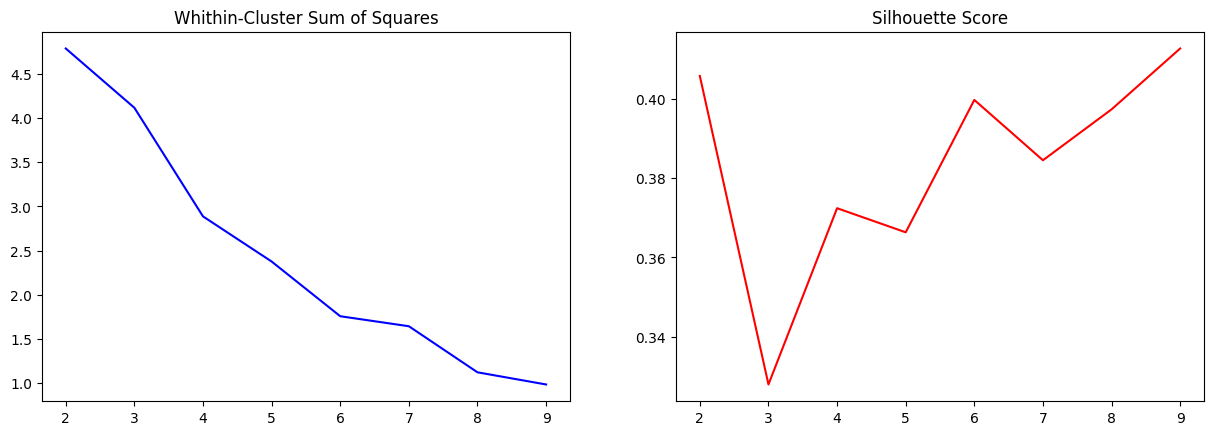

In [209]:
# Finding first guess of ideal cluster number using WCSS (Whithin-Cluster Sum of Squares)
# The higher the N, lower the WCSS. However beyond a certain point, the gain becomes marginal
wcss = []
sc = []
n_range = range(2, 10) 
for n in n_range:
    kmeans = KMeans(n_clusters=n, random_state=rs)
    kmeans.fit(df_features)

    labels = kmeans.predict(df_features)
    sc.append(silhouette_score(df_features, labels))

    wcss.append(kmeans.inertia_)

fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(15)

ax[0].plot(n_range, wcss, color="b")
ax[0].set_xticks(n_range)
ax[0].set_title("Whithin-Cluster Sum of Squares")

ax[1].plot(n_range, sc, color="r")
ax[1].set_xticks(n_range)
ax[1].set_title("Silhouette Score")

plt.grid(False)
plt.show()


==========================================================================================================
- The "knee" can be located mathematically by the second derivative or visualizing the WCSS plot.
- Silhouette score measures how well the clusters are separated, ranging from -1 to 1 (higher is better)

- For this task, k=6 was chosen because:
    1. it has a high sillhouette score param (Even though its far from 1)
    2. An "elbow" can be noticed

==========================================================================================================

In [210]:
k = 6

kmeans = KMeans(n_clusters=k, random_state=rs)
kmeans.fit(df_features)

df_features = df_features.sort_values(cluster_features[0])

# Predict to all values (outliers included)
df_features_full = df_failure[cluster_features].copy()
df_features_full[cluster_features] = scaler.transform(df_features_full)

clusters = kmeans.predict(df_features_full)
df_features_full["Scenario"] = clusters
df_failure["Scenario"] = clusters

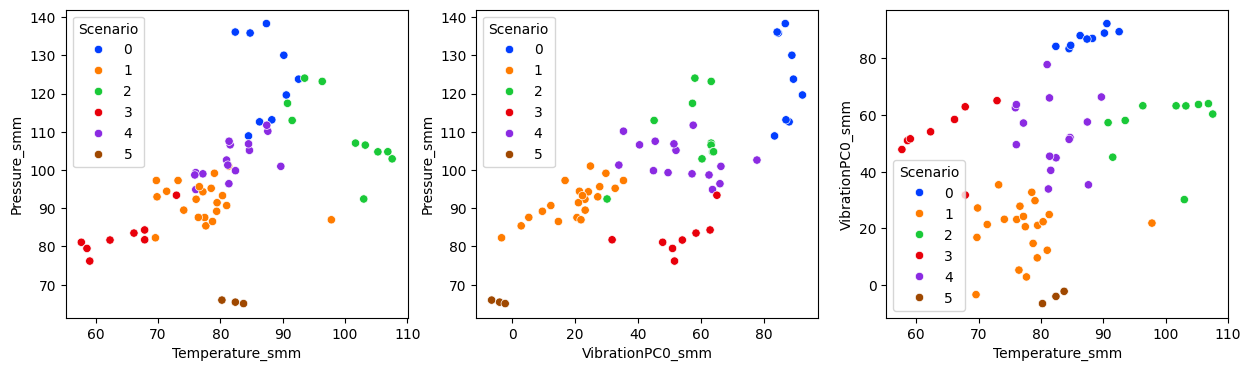

In [211]:
fig, ax = plt.subplots(nrows=1, ncols=3)
fig.set_figwidth(15)
fig.set_figheight(4)

sns.scatterplot(
    df_failure,
    x=cluster_features[0],
    y=cluster_features[1],
    hue="Scenario",
    palette="bright",
    ax=ax[0],
);

sns.scatterplot(
    df_failure,
    x=cluster_features[2],
    y=cluster_features[1],
    hue="Scenario",
    palette="bright",
    ax=ax[1]
);

sns.scatterplot(
    df_failure,
    x=cluster_features[0],
    y=cluster_features[2],
    hue="Scenario",
    palette="bright",
    ax=ax[2]
);

plt.show()

==========================================================================================================
Failure Scenarios:

- Scenario 0: High `Pressure` and `Vibration`, with moderate `Temperature` (Overload)
- Scenario 1: Moderate `Pressure` and `Temperature`, with low `Vibration` (Low frequency/rpm - electric failure?)
- Scenario 2: Slightly high `Pressure`, high `Temperature`, moderate `Vibration` (Overheat)
- Scenario 3: Low `Pressure` and `Temperature`, moderate `Vibration` (Pressure Drop)
- Scenario 4: Moderate `Pressure`, `Temperature` and `Vibration` (External Cause?)
- Scenario 5: Low `Pressure`, `Temperature` and `Vibration` (Underload)

==========================================================================================================


In [212]:
df_features_full.groupby("Scenario").mean()

,Temperature_smm,Pressure_smm,VibrationPC0_smm
Scenario,,,
0,0.642235,0.911230,0.948592
1,0.414921,0.413378,0.265594
2,0.925999,0.685723,0.641538
3,0.113280,0.271219,0.600925
4,0.516403,0.579925,0.608881
5,0.522093,0.006638,0.023127


==========================================================================================================

Note that this method may contain 2 or more scenarios in the same failure. Taking the most frequent category for each failure migh solve this problem.

==========================================================================================================

### 5.2. Second Approach
All the measurements of a failure must have the same classification.

In [214]:
df_failure.groupby(["StateID", "Scenario"])["Cycle"].count().sort_index()

StateID  Scenario
2        3           1
4        1           3
6        1           1
         2           1
         4           1
8        5           3
10       1           1
         2           1
12       0           9
         1           4
         4           5
14       3           7
         4           2
16       2           5
18       1           7
         2           3
         4           4
20       1           5
         4           3
Name: Cycle, dtype: int64

==========================================================================================================

`StateID`s 6 and 10 have same number of points and scenarios. The most frequent category won't work as expected.

==========================================================================================================

In [215]:
df_failure.groupby("StateID")["Scenario"].agg(pd.Series.mode)

StateID
2             3
4             1
6     [1, 2, 4]
8             5
10       [1, 2]
12            0
14            3
16            2
18            1
20            1
Name: Scenario, dtype: object

In [224]:
# workaround - taking only the fail start point
df_scenarios = df_failure[df_failure["FailStart"]].copy()
df_scenarios = df_scenarios.groupby("StateID", as_index=False)["Scenario"].agg(pd.Series.mode)
df_scenarios = df_scenarios.rename({"Scenario": "ScenarioAdjust"}, axis=1)

df_scenarios

,StateID,ScenarioAdjust
0,2,3
1,4,1
2,6,1
3,8,5
4,10,1
5,12,1
6,14,3
7,16,2
8,18,1
9,20,1


In [225]:
# df_failure["ScenarioAdjust"] = df_failure.groupby("StateID")["Scenario"].transform(lambda x: x.value_counts().index[0])
df_failure = df_failure.merge(df_scenarios, on="StateID", how="left")

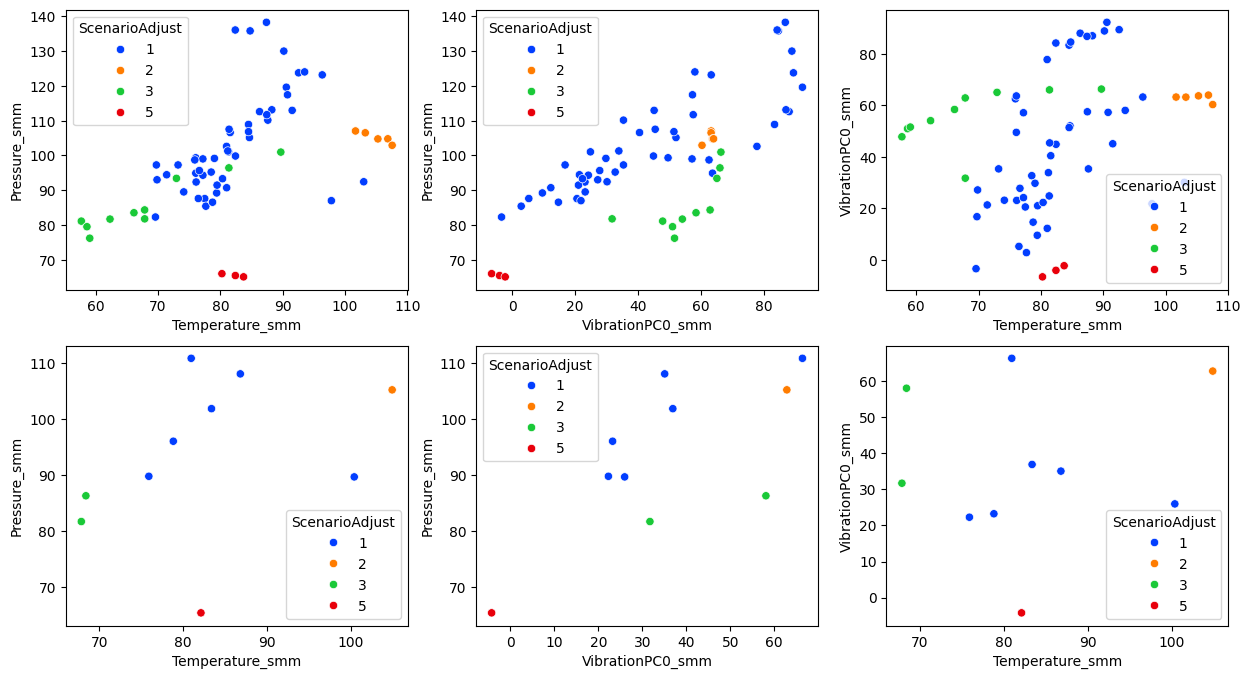

In [226]:
_df_failure = df_failure.groupby(["StateID", "ScenarioAdjust"], as_index=False)[cluster_features].mean()
# _df_failure = df_failure[df_failure["FailStart"]]

fig, ax = plt.subplots(nrows=2, ncols=3)
fig.set_figwidth(15)
fig.set_figheight(8)

sns.scatterplot(
    df_failure,
    x=cluster_features[0],
    y=cluster_features[1],
    hue="ScenarioAdjust",
    palette="bright",
    ax=ax[0][0],
);

sns.scatterplot(
    df_failure,
    x=cluster_features[2],
    y=cluster_features[1],
    hue="ScenarioAdjust",
    palette="bright",
    ax=ax[0][1]
);

sns.scatterplot(
    df_failure,
    x=cluster_features[0],
    y=cluster_features[2],
    hue="ScenarioAdjust",
    palette="bright",
    ax=ax[0][2]
);

sns.scatterplot(
    _df_failure,
    x=cluster_features[0],
    y=cluster_features[1],
    hue="ScenarioAdjust",
    palette="bright",
    ax=ax[1][0],
);

sns.scatterplot(
    _df_failure,
    x=cluster_features[2],
    y=cluster_features[1],
    hue="ScenarioAdjust",
    palette="bright",
    ax=ax[1][1]
);

sns.scatterplot(
    _df_failure,
    x=cluster_features[0],
    y=cluster_features[2],
    hue="ScenarioAdjust",
    palette="bright",
    ax=ax[1][2]
);

plt.show()

# NOTE: Copy paste is bad, but it was for a better cause

In [231]:
fig = px.scatter_3d(
    df_failure,
    x=cluster_features[0],
    y=cluster_features[1],
    z=cluster_features[2],
    color="Scenario",
)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [230]:
display(
    df_failure[df_failure["Scenario"] == 0][["FailStart", "FailMiddle", "FailEnd"]].sum(),
    df_failure[df_failure["Scenario"] == 4][["FailStart", "FailMiddle", "FailEnd"]].sum(),
)

FailStart     0
FailMiddle    8
FailEnd       1
dtype: int64

FailStart      0
FailMiddle    14
FailEnd        1
dtype: int64

==========================================================================================================

- Scenario 4 is no longer present. This can explain why all of its variables were moderate;
- Scenario 0 and 4 weren't root causes (None of their points were captured when fail starts);
- Some scenarios have lost their characteristics, for example:

==========================================================================================================

==========================================================================================================
Final Failure Scenarios:

- 1 (Scenario 1): High `Pressure` and `Vibration`, with moderate `Temperature` (Overload)
- 2 (Scenario 2): Slightly high `Pressure`, high `Temperature` and `Vibration` (Overheat)
- 3 (Scenario 3): Slighly low `Pressure`, slightly high `Temperature`, high `Vibration` (Pressure Drop)
- 4 (Scenario 5): Low `Pressure`, `Temperature` and `Vibration` (Underload)

_Understanding how each failure changes the system after it begins would be intersting, bur this analysis ends here._

==========================================================================================================
